# MHD Wave Dispersion Relations

This notebook introduces the linear, ideal-magnetohydrodynamic (MHD) waves and their properties using PlasmaPy's `mhd_waves_` module.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from plasmapy.dispersion.analytical.mhd_waves_ import (
    AlfvenWave,
    FastMagnetosonicWave,
    SlowMagnetosonicWave,
    mhd_waves,
)

## Introduction

### Set Up

Before using the `mhd_waves_` module, we must provide an ion species and fundamental plasma parameters for the ideal-MHD plasma we want to work with. Here, we will use protons and provide four sets of parameters that differ only in temperature $T$ so that each plasma has a different plasma beta, the ratio between the plasma pressure $p = n k_B T$ and magnetic pressure $p_m = B^2 / (2 \mu_0)$, or
$$
    \beta = \frac{p}{p_m} = \frac{n k_B T}{B^2 / (2 \mu_0)}
$$
where
* $n$ is the number density
* $k_B$ is the Boltzmann constant,
* $B$ is the magnetic field strength, and
* $\mu_0$ is the vacuum magnetic permeability.

In [2]:
plasma_T = [
    0.0 * u.K,      # beta = 0.00 (i.e., cold-plasma limit)
    1.45e6 * u.K,   # beta = 0.50
    3.45e6 * u.K,   # beta = 1.20
    7.2e6 * u.K,    # beta = 2.50
]

plasma = [
    {
        'B': 1e-3 * u.T,
        'density': 1e16 * u.m ** -3,
        'ion': 'p+',
        'T': T
    } for T in plasma_T
]

Additionally, the following plotting-related code will also be helpful.

In [3]:
color = ['g', 'r', 'b']
plt.rc('lines', linestyle='None', marker='.', markersize=1)

labels = ['Alfvén', 'Fast', 'Slow']

# Format axis


def ax_format(ax):
    ax.set(
        xlim=(-2, 2),
        ylim=(-2, 2),
        xticks=range(-2,3),
        yticks=range(-2,3),
        aspect=1,
    )
    ax.grid()

    # Plot arrow in direction of B
    ax.text(0.85, 0.9, 'B', transform=ax.transAxes)
    ax.arrow(0.8, 0.88, 0.1, 0, width=0.005, color='black', transform=ax.transAxes)

# Add legend


def fig_legend(fig):
    handles, labels = fig.axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3, markerscale=8)

### Derivation

The MHD dispersion relation can be derived from the system of ideal-MHD equations consisting of the momentum equation, ideal induction equation, continuity equation, and adiabatic energy equation expressed as
$$
\begin{align*}
    \rho \left(\frac{\partial}{\partial t} + \mathbf{u}\cdot\nabla\right) \mathbf{u} - \frac{1}{\mu_0} (\nabla \times \mathbf{B}) \times \mathbf{B} + \nabla p &= 0, \\
    \frac{\partial\mathbf{B}}{\partial t} - \nabla \times (\mathbf{u} \times \mathbf{B}) &= 0, \\
    \frac{\partial\rho}{\partial t} + \nabla \cdot (\rho\mathbf{u}) &= 0, \\
    \frac{d}{dt} \left(\frac{p}{\rho^\gamma}\right) &= 0,
\end{align*}
$$
respectively, where the flow velocity $\mathbf{u}$, magnetic field $\mathbf{B}$, mass density $\rho$, and plasma pressure $p$ are unknown and $\gamma$ is the adiabatic index. We assume that the equilibrium is stationary, with a uniform and constant magnetic field, density, and plasma pressure. We then assume that the unknowns take the form
$$
\begin{align*}
    \mathbf{u}(\mathbf{r},t) &= \mathbf{u}_1(\mathbf{r},t), \\
    \mathbf{B}(\mathbf{r},t) &= B_0 + \mathbf{B}_1(\mathbf{r},t), \\
    \rho(\mathbf{r},t) &= \rho_0 + \rho_1(\mathbf{r},t), \\
    p(\mathbf{r},t) &= p_0 + p_1(\mathbf{r},t),
\end{align*}
$$
where subscripts of 0 indicate equilibrium quantities and subscripts of 1 indicate small-amplitude, first-order corrections to these equilibrium quantities. With these assumptions the system of ideal-MHD equations reduces to a system of linear equations:
$$
\begin{align*}
    \rho_0 \frac{\partial\mathbf{u}_1}{\partial t} - \frac{1}{\mu_0} (\nabla \times \mathbf{B}_1) \times \mathbf{B}_0 + \nabla p_1 &= \mathbf{0}, \\
    \frac{\partial\mathbf{B}_1}{\partial t} - \nabla \times (\mathbf{u}_1 \times \mathbf{B}_0) &= \mathbf{0}, \\
    \frac{\partial\rho_1}{\partial t} + \rho_0\nabla \cdot \mathbf{u}_1 &= 0, \\
    \frac{\partial}{\partial t} \left(p_1 - \frac{\gamma p_0}{\rho_0} \rho_1\right) &= 0.
\end{align*}
$$

Additionally, we can re-express this system in terms of the displacement of the plasma $\boldsymbol{\xi}_1(\mathbf{r}, t) = \int_0^t \mathbf{u}_1(\mathbf{r}, t') dt'$ by integrating the linearized continuity equation, adiabatic energy equation, and ideal induction equation with respect to time and solving for their respective perturbed quantities:
$$
\begin{align*}
    \mathbf{B}_1 &= \nabla \times (\boldsymbol{\xi}_1 \times \mathbf{B}_0), \\
    \rho_1 &= - \rho_0 \nabla \cdot \boldsymbol{\xi}_1, \\
    p_1 &= - \gamma p_0 \nabla \cdot \boldsymbol{\xi}_1.
\end{align*}
$$
Substituting these into the linearized momentum equation gives an expression in terms of the displacement that can then be reduced to a system of linear _algebraic_ equations. First performing Fourier analysis, we assume that solutions are of the form of a superposition of plane waves, $\boldsymbol{\xi}_1(\mathbf{r}, t) \sim \exp [i(\mathbf{k} \cdot \mathbf{r} - \omega t)]$ for wavevectors $\mathbf{k}$ and angular frequencies $\omega$.

The wavevector $\mathbf{k}$ can also be expressed in terms of the angle $\theta$ subtended by $\mathbf{k}$ and $\mathbf{B}_0$. This allows us to write $k_\parallel = k \cos\theta$ and $k_\perp = k \sin\theta$ where $k = |\mathbf{k}|$.

Next, without loss of generality, we use a right-handed Cartesian coordinate system in which the equilibrium magnetic field $\mathbf{B}_0 = B_0 \hat{\mathbf{z}}$ lies along the $z$-axis and the wavevector $\mathbf{k} = k_\perp \hat{\mathbf{x}} + k_\parallel \hat{\mathbf{z}}$ lies in the $xz$-plane where $\hat{\mathbf{x}}$ and $\hat{\mathbf{z}}$ are the unit vectors along the $x$- and $z$-axis, respectively. The linearized momentum equation then can be expressed as the system of linear algebraic equations
$$
    \begin{pmatrix}
        \omega^2 - v_A^2 k^2 - c_s^2 k_\perp^2 & 0 & -c_s^2 k_\parallel k_\perp \\
        0 & \omega^2 - v_A^2 k_\parallel^2 & 0 \\
        -c_s^2 k_\parallel k_\perp & 0 & \omega^2 - c_s^2 k_\parallel^2
    \end{pmatrix}
    \begin{pmatrix}
        \xi_{x1} \\ \xi_{y1} \\ \xi_{z1}
    \end{pmatrix}
    =
    \begin{pmatrix}
        0 \\ 0 \\ 0
    \end{pmatrix}
$$
where $v_A = \sqrt{B_0/(\mu_0 \rho_0)}$ is the Alfvén speed and $c_s = \sqrt{\gamma p_0 / \rho_0}$ is the sound speed.

This system of algebraic equations is of the form of an eigenvalue-eigenvector problem for eigenvalues $\omega^2$. The three eigenvalues give the dispersion relations for the three MHD wave modes, and the corresponding eigenvectors give their polarizations. In order for there to be a non-trivial solution, the determinant of the coefficient matrix must be equal to zero. This condition gives the linear, ideal-MHD dispersion relation,
$$
    \boxed{
        \left(\omega^2 - v_A^2 k _\parallel^2\right) \left(\omega^4 - \omega^2 k^2 c_{ms}^2 + k^2 k_\parallel^2 v_A^2 c_s^2\right) = 0
    }
$$
where $c_{ms} = \sqrt{v_A^2 + c_s^2}$ is the magnetosonic speed (the significance of which will be discussed later).

## Alfvén Wave
The solution
$$
    \omega^2 = v_A^2 k^2 \cos^2 \theta
$$
to the MHD dispersion relation corresponds to the Alfvén wave. This mode is represented in PlasmaPy by the `AlfvenWave` class, which can be instantiated by providing fundamental plasma parameters as arguments.

In [4]:
alfven = AlfvenWave(**plasma[1])

The Alfvén wave is associated with the eigenvector $\boldsymbol{\xi}_1 = \boldsymbol{\xi}_{y1} \hat{\mathbf{y}}$, indicating that plasma is displaced perpendicular to both the direction of propagation and the equilibrium magnetic field such that $\mathbf{k} \cdot \mathbf{u}_1 = 0$ and $\mathbf{B}_0 \cdot \mathbf{u}_1 = 0$, respectively. Thus, the Alfvén wave is transverse and incompressive, not associated with density or plasma pressure perturbations. Alfvén waves are instead driven by magnetic tension, a tension force along the magnetic field that acts to straighten bent field lines.

For example, following a transverse deformation of a magnetic field line, magnetic tension will act as a restoring force to straighten the field line. Since the plasma is ideally conducting, the frozen-in condition applies, and displacement of the magnetic field is accompanied by displacement of the plasma (and vice versa). Therefore, as the bent magnetic field returns to its straight, equilibrium position, plasma is dragged along with the field and gains kinetic energy. When the field reaches its equilibrium position, the inertia of the plasma causes it to continue moving, dragging the magnetic field along with it thereby forming another transverse deformation in the field. The plasma and magnetic field eventually come to rest, and the process repeats.

Instances of the `AlfvenWave` class (along with instances of the `FastMagnetosonicWave` and `SlowMagnetosonicWave` classes introduced later) have attributes for the plasma beta, Alfvén speed, sound speed, and magnetosonic speed derived from the plasma parameters used to instantiate the class. For example,

In [5]:
{
    "Plasma beta": alfven.beta,
    "Alfvén speed": alfven.alfven_speed,
    "Sound speed": alfven.sound_speed,
    "Magnetosonic speed": alfven.magnetosonic_speed
}

{'Plasma beta': <Quantity 0.50314266>,
 'Alfvén speed': <Quantity 218060.97295233 m / s>,
 'Sound speed': <Quantity 141237.85875402 m / s>,
 'Magnetosonic speed': <Quantity 259805.15905258 m / s>}

The angular frequency for a given wavenumber $k$ and angle $\theta$ can be calculated using the `angular_frequency` method. The arguments for both $k$ and $\theta$ accept single values:

In [6]:
alfven.angular_frequency(1e-5 * u.rad / u.m, 0 * u.rad)

<Quantity 2.18060973 rad / s>

as well as lists of values:

In [7]:
alfven.angular_frequency([1e-5, 1e-6] * u.rad / u.m, [0, np.pi / 4, np.pi / 2] * u.rad)

<Quantity [[2.18060973e+00, 1.54192393e+00, 1.33523836e-16],
           [2.18060973e-01, 1.54192393e-01, 1.33523836e-17]] rad / s>

where the $n\text{th}$ row of the returned array holds values for the $n\text{th}$ wavenumber and the $m\text{th}$ column holds values for the $m\text{th}$ angle.

### Phase Velocity

The wavefront of a plane Alfvén wave propagates in the direction of a wavevector $\mathbf{k}$, which need not be parallel with the equilbrium magnetic field. For nonzero $v_A$ and $k$, the angular frequency only vanishes when $\mathbf{k}$ and $\mathbf{B}_0$ are orthogonal such that $\cos\theta = 0$. This wavefront propagates with a phase velocity $v_{ph} = \omega/k$ given by the expression
$$
    v_{ph}^2 = v_A^2 \cos^2 \theta.
$$

For a given $k$ and $\theta$, the phase velocity can be calculated using the `phase_velocity` method. For example,

In [8]:
k = 1e-5 * u.rad / u.m
theta = np.pi / 4 * u.rad

alfven.phase_velocity(k, theta)

<Quantity 154192.39268673 m / s>

For a given $v_A$, the phase velocity is greatest—equal to the Alfvén speed—when $\mathbf{k}$ and $\mathbf{B}_0$ are parallel:

In [9]:
alfven.phase_velocity(k, [0, np.pi] * u.rad) / alfven.alfven_speed

<Quantity [1., 1.]>

### Group Velocity

While the phase velocity can be oblique to the magnetic field, the group velocity $\mathbf{v}_g = d\omega/d\mathbf{k}$ is only ever directed along the magnetic field. It can be expressed as
$$
    \mathbf{v}_g = \pm\, \frac{\mathbf{B_0}}{\sqrt{\mu_0 \rho}} = \pm\, v_A\, \hat{\mathbf{z}}.
$$

For a given $k$ and $\theta$, the group velocity can be calculated using the `group_velocity` method:

In [10]:
alfven.group_velocity(k, theta)

[<Quantity 154192.39268673 m / s>, <Quantity [[-154192.39268673]] m / s>]

where the first element of the returned list gives the component of the group velocity in the direction of $\mathbf{k}$ and the second gives the component perpendicular to $\mathbf{k}$ and in the direction of increasing $\theta$.

In [11]:
vg = alfven.group_velocity(k, theta)
vg

[<Quantity 154192.39268673 m / s>, <Quantity [[-154192.39268673]] m / s>]

Information and energy therefore only propagate along magnetic field lines even when the wavevector is oblique to the field.

## Magnetosonic Waves
The solutions
$$
    \omega^2 = \frac{k^2}{2} \left(c_{ms}^2 \pm \sqrt{c_{ms}^4 - 4 v_A^2 c_s^2 \cos^2 \theta}\right)
$$
to the MHD dispersion relation correspond to the fast and slow magnetosonic waves; the upper sign gives the fast mode and the lower sign gives the slow mode. They are represented in PlasmaPy by the `FastMagnetosonicWave` and `SlowMagnetosonicWave` classes, respectively, and can be instantiated by providing fundamental plasma parameters as arguments.

In [12]:
fast = FastMagnetosonicWave(**plasma[1])
slow = SlowMagnetosonicWave(**plasma[1])

Both the fast and slow magnetosonic waves have eigenvectors that lie in the $\mathbf{k}$–$\mathbf{B}_0$-plane. As a result, they are essentially compressive but are neither transverse nor longitudinal. Furthermore, these eigenvectors, together with the eigenvector of the Alfvén wave, are mutually perpendicular.

Both the fast and slow waves are driven by pressure gradients formed by the compression and rarefaction of the plasma and magnetic field in addition to magnetic tension. However, the fast and slow modes differ in the phase of their plasma and magnetic field perturbations: the fast mode is associated with in-phase perturbations, whereas the slow mode is associated with anti-phase perturbations.


### Phase Velocity
The magnetosonic waves have phase velocity $v_\pm$ given by the expression
$$
    v_\pm^2 = \frac{1}{2} \left(c_{ms}^2 \pm \sqrt{c_{ms}^4 - 4 v_A^2 c_s^2 \cos^2 \theta}\right)
$$
where the upper sign gives the phase velocity for the fast wave and the lower sign gives the phase velocity for the slow wave.

For a given $k$ and $\theta$, the phase velocities can be calculated using the `phase_velocity` method:

In [13]:
(fast.phase_velocity(k, theta), slow.phase_velocity(k, theta))

(<Quantity 243991.88639495 m / s>, <Quantity 89256.26052983 m / s>)

### Group Velocity
The magnetosonic waves have group velocity $\mathbf{v}_{g \pm}$ given by the expression
$$
    \mathbf{v}_{g \pm} = \hat{\mathbf{k}} v_{\pm} + \hat{\boldsymbol{\theta}} \frac{d v_{\pm}}{d\theta}
$$
where $\hat{\mathbf{k}}$ and $\hat{\boldsymbol{\theta}}$ are unit vectors in the direction of $\mathbf{k}$ and increasing $\theta$, respectively.

For a given $k$ and $\theta$, the group velocities can be calculated using the `group_velocity` method:

In [14]:
(fast.group_velocity(k, theta), slow.group_velocity(k, theta))

([<Quantity 243991.88639495 m / s>, <Quantity 37695.95073543 m / s>],
 [<Quantity 89256.26052983 m / s>, <Quantity [[-103046.06169688]] m / s>])

### Properties
The properties of the fast and slow magnetosonic waves strongly depend on the angle of propagation $\theta$ and the parameter $\beta = 2 c_s^2 / (\gamma v_A^2)$ previously discussed.

When $\beta > 0$, both the fast and slow waves can propagate in directions oblique to the equilibrium magnetic field, being driven by magnetic tension, magnetic pressure gradients, and plasma pressure gradients. Additionally, for oblique waves, the phase speeds of fast waves are always _greater_ than the Alfvén speed, and the phase speeds of slow waves are always _less_ than the Alfvén speed.

We will now consider some limiting cases.

#### Cold-Plasma Limit

We will first consider the simplest case, the cold-plasma limit, i.e., $\beta = 0$. In this case, slow waves are said to be "frozen out" and are not present, while fast waves propagate isotropically with phase velocities equal to the Alfvén speed.

In [15]:
fast_cold = FastMagnetosonicWave(**plasma[0])
fast_cold.phase_velocity(k, [0, np.pi / 3, 2 * np.pi / 3, np.pi] * u.rad) / fast_cold.alfven_speed

<Quantity [1., 1., 1., 1.]>

When oblique to the field, the fast waves are driven by both magnetic tension and magnetic pressure gradients, and, when parallel to the field, they are driven only by magnetic tension (thus degenerating into Alfvén waves).

When propagating perpendicular to the field, the fast waves are driven only by magnetic pressure gradients. As such, fast waves in the cold-plasma limit are sometimes referred to as _compressional Alfvén waves_. For example, a plane fast wave propagating perpendicular to the field in a cold plasma with homogeneous equilibrium density and magnetic field is associated with cospatial compression (rarefaction) of magnetic field lines and plasma. From compressed to rarefied regions there is a negative magnetic pressure gradient, which gives rise to a force directed across the magnetic field. The plasma and magnetic field thus move together from compressed to rarefied regions. However, the inertia of the plasma results in it together with the magnetic field overshooting the latter's equilibrium position, thereby forming new regions of compression and rarefaction. The process then repeats.

#### Perpendicular Propagation

When $\beta > 0$, the effects of plasma pressure must also be taken into account.

Considering the case of a plane fast wave propagating perpendicular to the field but this time in a plasma with nonzero $\beta$, the fast wave is still associated with cospatial compression (rarefaction) of magnetic field lines and plasma; however, from compressed to rarefied regions there are both negative magnetic and plasma pressure gradients. They together give rise to force directed across the magnetic field, and the plasma and magnetic field move together from compressed to rarefied regions. The inertia of the plasma results in the plasma and magnetic field overshooting their equilibria, thereby forming new regions of compression and rarefaction. The process then repeats.

When propagating perpendicular to the field, the phase and group velocities of fast waves have magnitude equal to the _magnetosonic speed_ or _fast speed_,
$$
    c_{ms} = \sqrt{v_A^2 + c_s^2},
$$
which is always greater than both the Alfvén and sound speeds, reflecting the contributions from both magnetic and plasma pressure.

In [16]:
vph = fast.phase_velocity(k, np.pi / 2 * u.rad)
vg = fast.group_velocity(k, np.pi / 2 * u.rad)
vg_mag = np.sqrt(vg[0] ** 2 + vg[1] ** 2)

(vph / fast.magnetosonic_speed, vg_mag / fast.magnetosonic_speed)

(<Quantity 1.>, <Quantity 1.>)


In contrast to this behavior, slow waves cannot propagate perpendicular to the field. The phase velocities of slow waves tend to zero in the perpendicular direction while their group velocities tend toward what is referred to as the _tube speed_, _cusp speed_, or _slow speed_,
$$
    c_T = \frac{v_A c_s}{\sqrt{v_A^2 + c_s^2}},
$$
which is always less than both the Alfvén and sound speeds.

In [17]:
tube_speed = slow.alfven_speed * slow.sound_speed / slow.magnetosonic_speed
vg = slow.group_velocity(k, [89.99, 90] * u.deg)

np.sqrt(vg[0] ** 2 + vg[1] ** 2) / tube_speed

<Quantity [[1.00000001, 0.        ]]>

#### Parallel Propagation

In general, fast and slow waves propagating parallel to the equilibrium magnetic field degenerate into either pure Alfvén waves or pure acoustic waves with the faster of the two identified with fast waves and the slower identified with slow waves.

In [18]:
# `fast` and `slow` have beta < 1
print(fast.phase_velocity(k, 0 * u.rad) / fast.alfven_speed)
print(slow.phase_velocity(k, 0 * u.rad) / slow.sound_speed)

fast_large_beta = FastMagnetosonicWave(**plasma[3])
slow_large_beta = SlowMagnetosonicWave(**plasma[3])
print(fast_large_beta.phase_velocity(k, 0 * u.rad) / fast_large_beta.sound_speed)
print(slow_large_beta.phase_velocity(k, 0 * u.rad) / slow_large_beta.alfven_speed)

0.9999999999999999
1.0
1.0000000000000002
0.9999999999999998


## Plotting

As has been established, the phase and group velocities of linear ideal MHD's Alfvén, fast, and slow waves all depend on the plasma beta, the angle $\theta$ subtended by the wavevector and equilibrium magnetic field, or both. We can visualize these relationships using polar plots referred to as _Friedrichs diagrams_ (Friedrichs & Kranzer 1958). We will plot phase and group velocities for the fixed wavenumber $k = 10^{-5}\ \text{rad/m}$ and angles $0 \leq \theta < 2\pi\ \text{rad}$,

In [19]:
theta = np.linspace(0, np.pi * 2, 400) * u.rad

Additionally, we will create four subplots using the four sets of fundamental plasma parameters of differing plasma betas extablished previously in the list `plasma`. For each set of parameters, we will use PlasmaPy's `mhd_waves` method to return a dictionary of Alfvén, fast, and slow wave objects instantiated with that set of parameters.

In [20]:
waves = [mhd_waves(**params_dict) for params_dict in plasma]

for wave_dict_index, wave_dict in enumerate(waves):
    print(f"Index: {wave_dict_index}, β = {wave_dict[0].beta:.2f}")

Index: 0, β = 0.00
Index: 1, β = 0.50
Index: 2, β = 1.20
Index: 3, β = 2.50


Note that $\beta = 1.20$ was chosen since if $\gamma = 5/3$, as is the case here, then $\beta = 1.20$ implies that $c_s^2 / v_A^2 = 1$.

First, we will plot the phase velocities with Alfvén, fast, and slow waves in green, red, and blue, respectively.

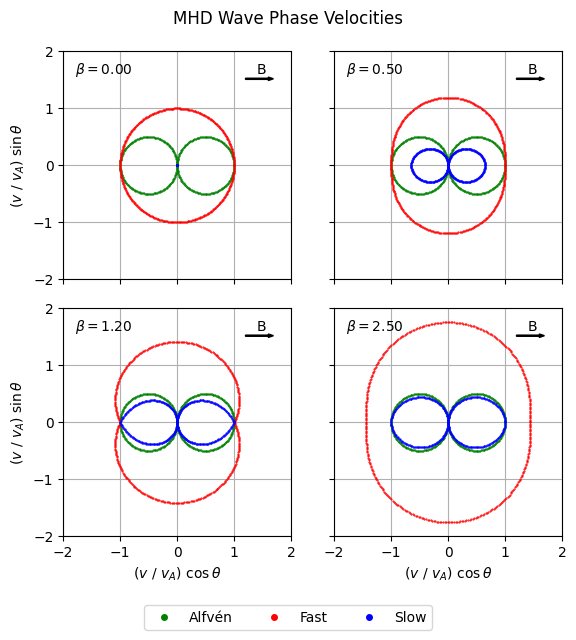

In [21]:
fig1, ax1 = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 6),
    sharex='col',
    sharey='row',
)

for row in range(2):
    for col in range(2):
        subplot_index = 2 * row + col

        for mode_index, mode in enumerate(waves[subplot_index]):
            vph_r = mode.phase_velocity(k, theta)
            ax1[row][col].plot(
                ((vph_r * np.cos(theta)) / mode.alfven_speed).value,
                ((vph_r * np.sin(theta)) / mode.alfven_speed).value,
                color[mode_index],
                label=labels[mode_index]
            )

        ax_format(ax1[row][col])
        text = rf'$\beta = {waves[subplot_index][0].beta:.2f}$'
        ax1[row][col].text(0.05, 0.9, text, transform=ax1[row][col].transAxes)

    ax1[1][row].set_xlabel(r'$(v\ /\ v_A) \ \cos \theta$')
    ax1[row][0].set_ylabel(r'$(v\ /\ v_A) \ \sin \theta$')

fig_legend(fig1)

fig1.suptitle('MHD Wave Phase Velocities')
fig1.tight_layout()
plt.show()

Second, we will plot the group velocities with Alfvén, fast, and slow waves in green, red, and blue, respectively, and the Alfvén wave marker enlarged.

In [22]:
fig2, ax2 = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 6),
    sharex='col',
    sharey='row',
)

for row in range(2):
    for col in range(2):
        subplot_index = 2 * row + col

        for mode_index, mode in enumerate(reversed(waves[subplot_index])):
            vg_r, vg_theta = mode.group_velocity(k, theta)

            ax2[row][col].plot(
                ((vg_r * np.cos(theta) + vg_theta * np.cos(theta + np.pi / 2 * u.rad)) / mode.alfven_speed).value,
                ((vg_r * np.sin(theta) + vg_theta * np.sin(theta + np.pi / 2 * u.rad)) / mode.alfven_speed).value,
                color[2 - mode_index],
                markersize=1 if 2 - mode_index != 0 else 4,  # Enlarge Alfven marker
            )

        ax_format(ax2[row][col])
        text = rf'$\beta = {waves[subplot_index][0].beta:.2f}$'
        ax2[row][col].text(0.05, 0.9, text, transform=ax2[row][col].transAxes)

    ax2[1][row].set_xlabel(r'$(v\ /\ v_A) \ \cos \theta$')
    ax2[row][0].set_ylabel(r'$(v\ /\ v_A) \ \sin \theta$')

fig2.suptitle('MHD Wave Group Velocities')
fig2.tight_layout()
plt.show()

## Bibliography

* Bellan, Paul Murray (2006). _Fundamentals of Plasma Physics_. Cambridge: Cambridge University Press. ISBN 0521528003.
* Boyd, T. J. M.; Sanderson, J.J. (2003). _The Physics of Plasmas_. Cambridge: Cambridge University Press. doi:10.1017/CBO9780511755750
* Friedrichs, K. O.; Kranzer, H. (1958). "Notes on Magneto-hydrodynamics VIII: Nonlinear Wave Motion". New York University Report NYO 6486-VIII. https://archive.org/details/notesonmagnetohy08frie
* Nakariakov, V. M. (2020). Magnetohydrodynamic Waves. _Oxford Research Encyclopedia of Physics_. doi:10.1093/acrefore/9780190871994.013.7
* Somov, Boris V. (2012). _Plasma Astrophysics, Part I: Fundamentals and Practice_ (2nd ed.). New York, NY: Springer. ISBN 978-1-4614-4283-7.